# Sentiment Analysis on Chat Data from telegram group chats

# Introduction
Telegram hosts a very large number of group chats where users can interact with each other. These group chats can be used for various purposes, such as discussing common interests, sharing information, or organizing events. In this project, I will perform sentiment analysis on chat data from a Telegram group chat. The chat data contains messages from multiple users, and we will analyze the sentiment of these messages to understand the overall sentiment of the group chat.

The goal of this project is to build a sentiment analysis model that can classify the sentiment of chat messages as positive, negative, or neutral. We will use a dataset of chat messages from a Telegram group chat and preprocess the data to prepare it for sentiment analysis. We will then train a sentiment analysis model using a machine learning algorithm and evaluate its performance. Finally, we will use the trained model to predict the sentiment of new chat messages.  This models will help telegram group chat admins to monitor the chat and know the sentiment of the chat and take necessary actions. telegram bots can also be used to monitor the chat and give feedback to the admins.

In [1]:
# This block of code imports the necessary libraries for the project all the necessary libraries are imported here and no need to import them again in the code 


import os
import json
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning, module='matplotlib')
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Telegram Chat Data
The chat data is stored in a JSON file and contains information about the messages sent in the group chat. This data includes the text of the messages, the sender of the messages, the date and time the messages were sent, and other relevant information. We will load this data into a DataFrame and preprocess it to prepare it for sentiment analysis.


In [2]:
# Load JSON file

data_path = os.path.join("data", "bot.json") 
with open(data_path, "r", encoding="utf-8") as file:
    chat_data = json.load(file)


# Data Preprocessing
We need to set messages to the data frame because we are interested in the messages sent in the chat data.


In [3]:
# Convert JSON to DataFrame
df = pd.DataFrame(chat_data['messages'])
df.tail()

,id,type,date,date_unixtime,actor,actor_id,action,title,text,text_entities,...,game_message_id,score,saved_from,location_information,invoice_information,place_name,address,reply_to_peer_id,giveaway_information,boosts
474259,945379,message,2024-12-01T17:03:44,1733061824,NaN,NaN,NaN,NaN,"[{'type': 'mention', 'text': '@BotFather'}, >...","[{'type': 'mention', 'text': '@BotFather'}, {'...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474260,945381,message,2024-12-01T17:07:05,1733062025,NaN,NaN,NaN,NaN,Thanks for your help),"[{'type': 'plain', 'text': 'Thanks for your he...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474261,945382,message,2024-12-01T17:10:09,1733062209,NaN,NaN,NaN,NaN,"Can i edit message with media, and delete medi...","[{'type': 'plain', 'text': 'Can i edit message...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474262,945385,message,2024-12-01T17:42:28,1733064148,NaN,NaN,NaN,NaN,Why you ignore me?,"[{'type': 'plain', 'text': 'Why you ignore me?'}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
474263,945386,message,2024-12-01T17:43:00,1733064180,NaN,NaN,NaN,NaN,Because your message doesn't make sense. What ...,"[{'type': 'plain', 'text': 'Because your messa...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Exploration and Visualization
We will explore the chat data to understand its structure and contents. We will visualize the data to gain insights into the number of messages, the distribution of messages per user, the text length distribution, and the message frequency over time. This help us to have a clear understanding of the data before we start the cleaning process.

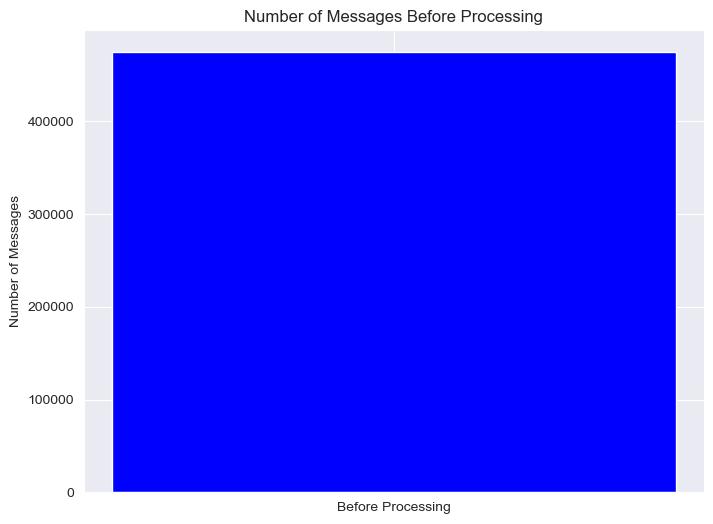

In [4]:
#  Number of Messages Before Processing

num_messages_before = df.shape[0]

plt.figure(figsize=(8, 6))
plt.bar(['Before Processing'], [num_messages_before], color='blue')
plt.title('Number of Messages Before Processing')
plt.ylabel('Number of Messages')
plt.show()


In [6]:
#  Number of Messages Before Processing  and the top 10 users by message count

user_counts = df['from'].value_counts()
top_users = user_counts[:10]  # Top 10 users
message_ranges = user_counts.value_counts(bins=10).sort_index()  # Group users into ranges
user_counts = user_counts.apply(lambda x: ''.join(char for char in str(x) if char.isalnum()))
# Display summaries
print("Top 10 Users by Message Count:")
print(top_users)
print("\nUser Message Ranges:")
print(message_ranges)

Top 10 Users by Message Count:
from
dot                      30299
Яico X                   16857
Thorbijoern ᚛ᚃᚒᚉ ᚅᚎᚄ᚜    13046
Para                      8719
s0m31                     7988
Watzon 🍉🇵🇸                7163
Poolitzer X               6552
Lord unreal4u 𝕏 (NL)      3813
puppy0cam                 3242
Sköll                     3032
Name: count, dtype: int64

User Message Ranges:
(-29.299, 3030.8]     22152
(3030.8, 6060.6]          3
(6060.6, 9090.4]          4
(9090.4, 12120.2]         0
(12120.2, 15150.0]        1
(15150.0, 18179.8]        1
(18179.8, 21209.6]        0
(21209.6, 24239.4]        0
(24239.4, 27269.2]        0
(27269.2, 30299.0]        1
Name: count, dtype: int64


/tmp/ipykernel_20461/3502102848.py:10: UserWarning: Glyph 5787 (\N{OGHAM FEATHER MARK}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_20461/3502102848.py:10: UserWarning: Glyph 5763 (\N{OGHAM LETTER FEARN}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_20461/3502102848.py:10: UserWarning: Glyph 5778 (\N{OGHAM LETTER UR}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_20461/3502102848.py:10: UserWarning: Glyph 5769 (\N{OGHAM LETTER COLL}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_20461/3502102848.py:10: UserWarning: Glyph 5765 (\N{OGHAM LETTER NION}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_20461/3502102848.py:10: UserWarning: Glyph 5774 (\N{OGHAM LETTER STRAIF}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_20461/3502102848.py:10: UserWarning: Glyph 5764 (\N{OGHAM LETTER SAIL}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_20461/3502102848.py:10: UserWar

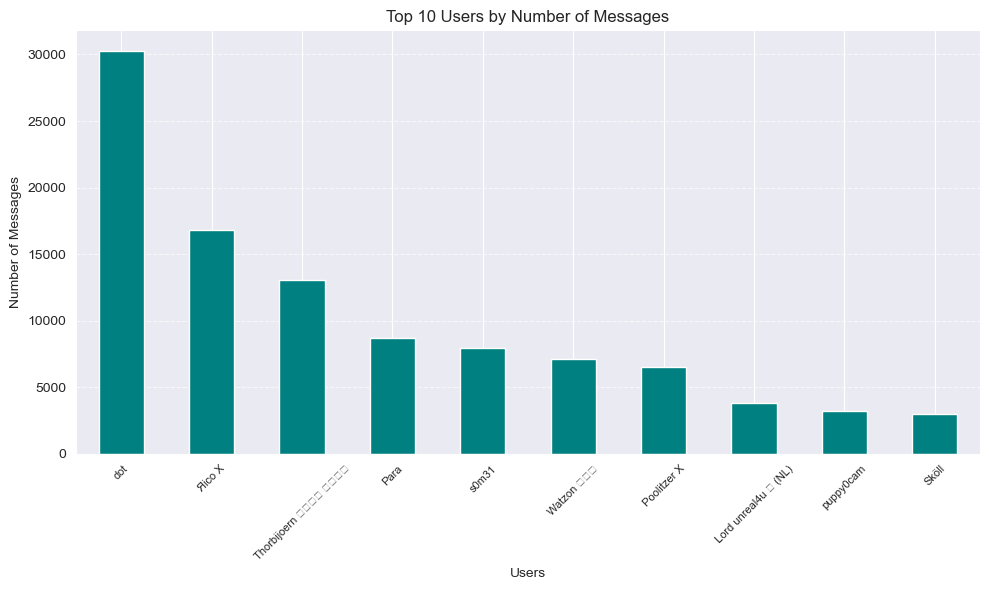

In [11]:
# Bar Chart for Top Users

plt.figure(figsize=(10, 6))
top_users.plot(kind='bar', color='teal')
plt.title("Top 10 Users by Number of Messages")
plt.xlabel("Users")
plt.ylabel("Number of Messages")
plt.xticks(rotation=45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

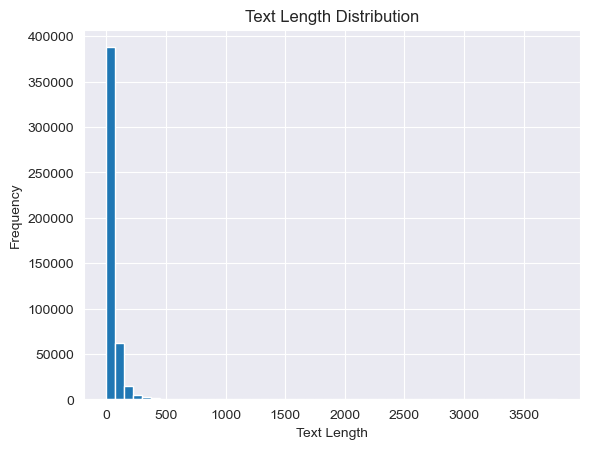

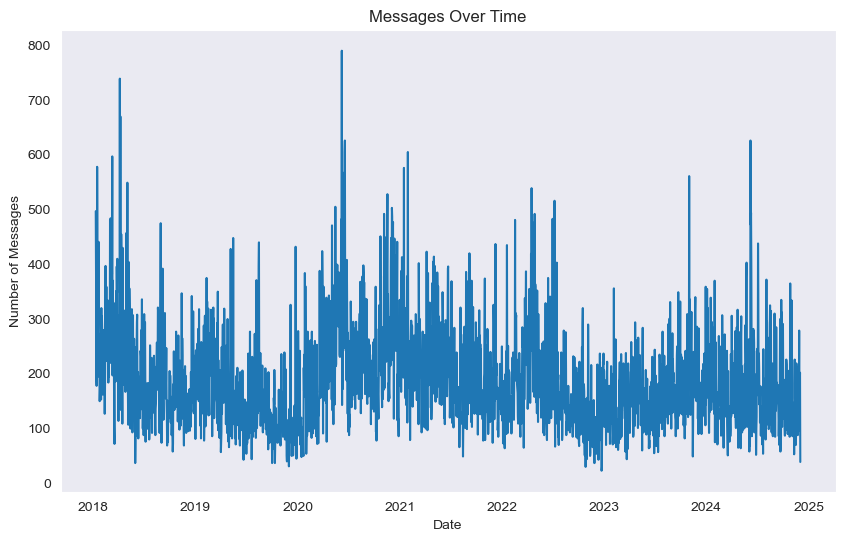

In [12]:
# Check text distribution and trends



df['text_length'] = df['text'].str.len()
plt.hist(df['text_length'], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


df['date'] = pd.to_datetime(df['date'])
plt.figure(figsize=(10, 6))
df['date'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title("Messages Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Messages")
plt.grid()
plt.show()


# Data Cleaning
We will clean the chat data by removing irrelevant columns, removing null or empty text, removing emojis, removing special characters, numbers, and punctuation, converting text to lowercase, removing short messages, and duplicates, and tokenizing the text into sentences. This will help us to prepare the data for sentiment analysis and improve the performance of the sentiment analysis model.
## why we need to clean the data
As we need to identify the mood of text message we need only the text message.  We don't need user, time, date and other information in the chat data so we need to remove them. We also need to remove null or empty text, emojis, special characters, numbers, and punctuation, convert text to lowercase, remove short messages, and duplicates, and tokenize the text into sentences. This will help us to prepare the data for sentiment analysis and improve the performance of the sentiment analysis model.

In [14]:
# Step 1: Extract the relevant columns (just text)
df = pd.DataFrame(chat_data['messages'])
df = df[['text']]  # Keep only the text column
df.head()

,text
0,
1,
2,
3,
4,


In [15]:
# Step 2: Remove rows with null or empty text
df = df[df['text'].notna() & (df['text'].str.strip() != '')]
df.head()

,text
8,[Hey! This is a chat where you can talk about...
26,Hello for everyone! My name is Davronbek Rusta...
29,Welcome everyone!
32,Hello! \(^-^)/
36,Bonjour


In [16]:
# Step 3: Remove emojis (non-ASCII characters)
df['text'] = df['text'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
df.head()

,text
8,NaN
26,Hello for everyone! My name is Davronbek Rusta...
29,Welcome everyone!
32,Hello! \(^-^)/
36,Bonjour


In [17]:
# Step 4: Remove special characters, numbers, and punctuation (keep only alphabets and spaces)

df['text'] = df['text'].str.replace(r"[^a-zA-Z\s]", '', regex=True)
df.tail()

,text
474259,NaN
474260,Thanks for your help
474261,Can i edit message with media and delete media...
474262,Why you ignore me
474263,Because your message doesnt make sense What is...


In [18]:
# Step 5: Convert text to lowercase and strip extra spaces, and NaN values
df['text'] = df['text'].str.lower().str.strip()
df['text'] = df['text'].fillna('')
df.tail()

,text
474259,
474260,thanks for your help
474261,can i edit message with media and delete media...
474262,why you ignore me
474263,because your message doesnt make sense what is...


In [19]:
# Step 6: Remove short messages (less than 3 characters) and duplicates
df = df[df['text'].str.len() > 3]
df = df.drop_duplicates(subset=['text'], keep='first')
df.head()

,text
26,hello for everyone my name is davronbek rustam...
29,welcome everyone
32,hello
36,bonjour
44,bonjour love


In [20]:
# Step 7: Tokenize the text into sentences

df = df['text'].apply(sent_tokenize).explode().reset_index(drop=True)

df = pd.DataFrame(df, columns=['text'])

# Check the result
df.head()


,text
0,hello for everyone my name is davronbek rustam...
1,welcome everyone
2,hello
3,bonjour
4,bonjour love


# Data Cleaning Summary 
After cleaning the chat data, we have removed irrelevant columns, removed null or empty text, removed emojis, removed special characters, numbers, and punctuation, converted text to lowercase, removed short messages, and duplicates, and tokenized the text into sentences. The cleaned data is now ready for sentiment analysis. Before that we can take a look at the cleaned data and see how it looks like as compared to the original data. 

## Total number of messages: 300,000
The number of messages after cleaning is 300,000, which is a significant reduction from the original number of messages. The original was more than 400, 000.  This shows that the cleaning process was effective in removing irrelevant and duplicate messages from the chat data.

In [21]:
# after I made  clean action on the chat data we can see how it looks like 


df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Summary statistics
num_messages = df.shape[0]
avg_word_count = df['word_count'].mean()

print(f"Total number of messages: {num_messages}")
print(f"Average word count per message: {avg_word_count:.2f}")


Total number of messages: 306625
Average word count per message: 12.54


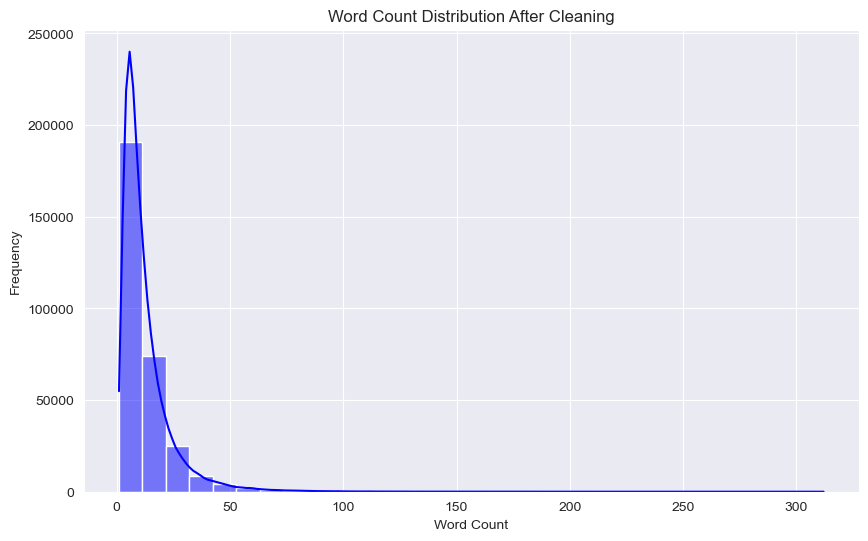

In [22]:
# Visualize the word count distribution


plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True, color='blue')
plt.title('Word Count Distribution After Cleaning')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()


The number of messages (Text) before cleaning was far more than 400, 000 and after cleaning as shown below is in 300,000 this shows the cleaning contributed a lot in reducing the number of messages  

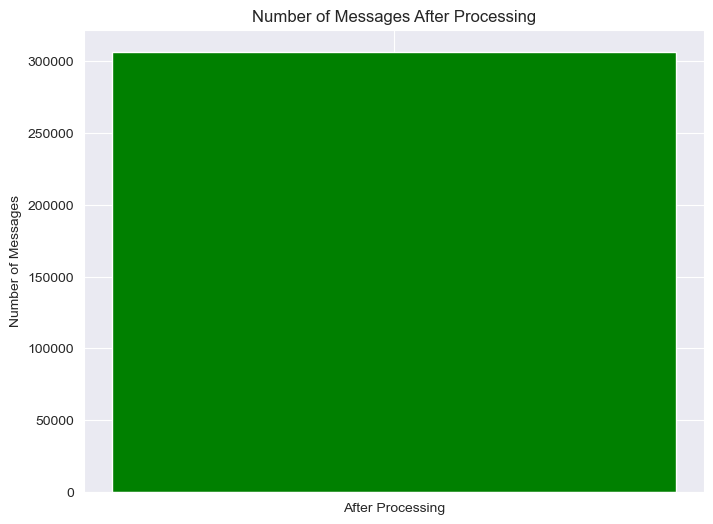

In [23]:
# we can compare the number of messages before and after cleaning

# Visualization: Number of Messages After Processing
num_messages_after = df.shape[0]

plt.figure(figsize=(8, 6))
plt.bar(['After Processing'], [num_messages_after], color='green')
plt.title('Number of Messages After Processing')
plt.ylabel('Number of Messages')
plt.show()


Below shows the number of messages before and after processing

# Comparison: Number of Messages Before and After Processing

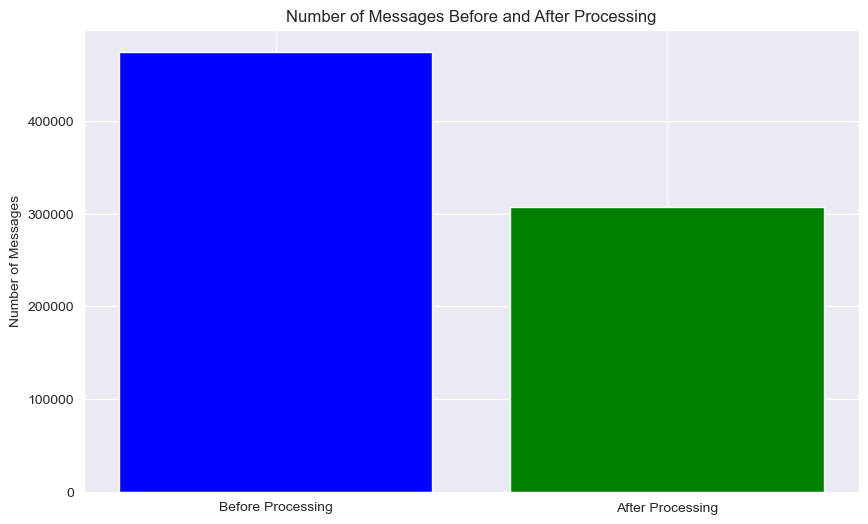

In [24]:
# Comparison: Number of Messages Before and After Processing
plt.figure(figsize=(10, 6))
plt.bar(['Before Processing', 'After Processing'], 
        [num_messages_before, num_messages_after], 
        color=['blue', 'green'])
plt.title('Number of Messages Before and After Processing')
plt.ylabel('Number of Messages')
plt.show()


# Text Vectorization
We will use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorization technique to convert the text data into numerical features that can be used for sentiment analysis. This will help us to represent the text data in a format that can be used by machine learning algorithms. We will use the TF-IDF vectorizer to convert the text data into a matrix of TF-IDF features. The TF-IDF vectorizer will convert the text data into a matrix of TF-IDF features, which will be used as input to the sentiment analysis model. We will also add a sentiment label to the text data based on the sentiment of the text messages. This will help us to train a sentiment analysis model that can classify the sentiment of chat messages as positive, negative, or neutral.

In [25]:

# TF-IDF Vectorization and saving it for later use

tfidf = TfidfVectorizer(max_features=10000) 

X_tfidf = tfidf.fit_transform(df['text'])

# Check the shape of the transformed data
print(X_tfidf.shape)


joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')

(306625, 10000)


['models/tfidf_vectorizer.pkl']

# Adding Sentiment Labels
We will add sentiment labels to the text data based on the sentiment of the text messages. We will use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool to analyze the sentiment of the text messages and assign sentiment labels to the text data. The VADER sentiment analysis tool is specifically designed for social media text and provides a sentiment score for each text message.

In [26]:
# adding sentiment to the text data

analyzer = SentimentIntensityAnalyzer()


df['sentiment'] = df['text'].apply(lambda x: 'positive' if analyzer.polarity_scores(x)['compound'] > 0 
                                   else 'negative' if analyzer.polarity_scores(x)['compound'] < 0 
                                   else 'neutral')


df.head()

,text,word_count,sentiment
0,hello for everyone my name is davronbek rustam...,14,positive
1,welcome everyone,2,positive
2,hello,1,neutral
3,bonjour,1,neutral
4,bonjour love,2,positive


 # Distribution of Sentiment Labels

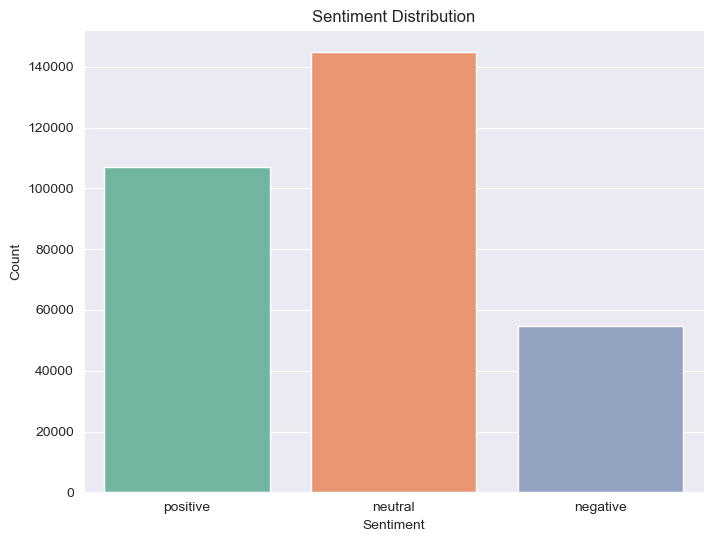

In [27]:

# Visualize the sentiment distribution this will how the sentiment is distributed in the chat data

plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=df, hue='sentiment', palette='Set2', legend=False)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


# Encoding the Sentiment Labels
We will encode the sentiment labels using LabelEncoder to convert the sentiment labels into numerical values that can be used by machine learning algorithms. This will help us to train a sentiment analysis model that can classify the sentiment of chat messages as positive, negative, or neutral.

In [29]:
# Encoding the sentiment labels using LabelEncoder  and save the label encoder for later use

label_encoder = LabelEncoder()


y = label_encoder.fit_transform(df['sentiment'])


joblib.dump(label_encoder, 'models/label_encoder.pkl')


print(label_encoder.classes_)
print(y[:100]) 
df.head(1000)


['negative' 'neutral' 'positive']
[2 2 1 1 2 2 0 1 0 0 1 2 2 1 1 1 0 1 2 1 1 1 0 1 1 1 2 1 0 2 2 1 2 1 1 2 2
 1 1 1 1 2 2 1 1 1 0 1 0 1 0 1 1 0 2 1 1 2 0 1 1 2 2 1 1 2 1 1 1 2 1 1 1 2
 2 1 1 1 1 1 1 2 2 2 1 2 2 1 2 0 0 2 2 1 1 1 1 1 2 2]


,text,word_count,sentiment
0,hello for everyone my name is davronbek rustam...,14,positive
1,welcome everyone,2,positive
2,hello,1,neutral
3,bonjour,1,neutral
4,bonjour love,2,positive
...,...,...,...
995,eh choose language,3,neutral
996,found this really cool maybe help later with g...,9,positive
997,do you guys have good open source bots written...,23,positive
998,cheers youre the best,4,positive


# Splitting the Data
We will split the data into training and testing sets to train the sentiment analysis model and evaluate its performance. We will use 80% of the data for training and 20% of the data for testing. This will help us to train the model on a subset of the data and evaluate its performance on unseen data.

In [30]:
# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(245300, 10000) (61325, 10000) (245300,) (61325,)


# Train a Logistic Regression model for sentiment classification and evaluate its performance
The next step is to train a sentiment analysis model using a machine learning algorithm. We will use a Logistic Regression model to classify the sentiment of chat messages as positive, negative, or neutral. We will train the model on the training data and evaluate its performance on the testing data using classification metrics such as precision, recall, and F1-score.

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.86      | 0.74   | 0.80     | 11029   |
| 1     | 0.95      | 0.99   | 0.97     | 28652   |
| 2     | 0.90      | 0.91   | 0.91     | 21644   |
| **Accuracy** |           |        | **0.92** | **61325** |
| **Macro avg** | 0.91      | 0.88   | 0.89     | 61325   |
| **Weighted avg** | 0.92      | 0.92   | 0.92     | 61325   |

And the model has an accuracy of 0.92, which is quite good. The model performs well in classifying the sentiment of chat messages as positive, negative, or neutral.
Note that class 0 is negative, class 1 is neutral, and class 2 is positive.


In [32]:
# Train a Logistic Regression model for sentiment classification and evaluate its performance


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.86      0.74      0.80     11029
           1       0.95      0.99      0.97     28652
           2       0.90      0.91      0.91     21644

    accuracy                           0.92     61325
   macro avg       0.91      0.88      0.89     61325
weighted avg       0.92      0.92      0.92     61325



# Hyperparameter Tuning
We will use GridSearchCV to tune the hyperparameters of the Logistic Regression model and find the best parameters for the model. This will help us to improve the performance of the model and optimize the hyperparameters for better results.

 | Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| 0       | 0.87      | 0.78   | 0.82     | 11029   |
| 1       | 0.98      | 0.99   | 0.99     | 28652   |
| 2       | 0.90      | 0.93   | 0.91     | 21644   |
| **Accuracy** |           |        | **0.93** | 61325   |
| **Macro Avg** | 0.92      | 0.90   | 0.91     | 61325   |
| **Weighted Avg** | 0.93      | 0.93   | 0.93     | 61325   |

The model has an accuracy of 0.93 after hyperparameter tuning, which is an improvement over the initial model. The model performs well in classifying the sentiment of chat messages as positive, negative, or neutral. The hyperparameter tuning helped to optimize the model and improve its performance.



In [48]:
# Hyperparameter Tuning using GridSearchCV for Logistic Regression model THIS WILL HELP TO FIND THE BEST PARAMETERS FOR THE MODEL




param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}


grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(classification_report(y_test, y_pred_best))


Best parameters: {'C': 10, 'solver': 'liblinear'}
Best score: 0.9305177333876886
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     11029
           1       0.98      0.99      0.99     28652
           2       0.90      0.93      0.91     21644

    accuracy                           0.93     61325
   macro avg       0.92      0.90      0.91     61325
weighted avg       0.93      0.93      0.93     61325



# Saving the Model
We will save the trained sentiment analysis model using joblib so that we can use it later to predict the sentiment of new chat messages. The model will be saved as a .pkl file in the models directory. This will help us to reuse the model without having to retrain it every time we want to make predictions.

In [33]:
os.makedirs('models', exist_ok=True)
joblib.dump(model, 'models/sentiment_model.pkl')
print("Model saved in 'models/sentiment_model.pkl'")



Model saved in 'models/sentiment_model.pkl'


In [35]:
model = joblib.load('models/sentiment_model.pkl')
model

LogisticRegression(max_iter=1000)

# Testing the Model with New and unlabeled Data
We will test the sentiment analysis model with new chat messages that are not labeled with sentiment. We will use the TF-IDF vectorizer to transform the new chat messages into numerical features and predict the sentiment of the messages using the trained model. This will help us to classify the sentiment of new chat messages as positive, negative, or neutral.

In [50]:
# Example new data
new_chat_messages = [
    "I love this feature!",
    "This is the worst experience ever.",
    "Nothing will happen.",
    "i have no mentor",
    "no sound"
]


new_data_tfidf = tfidf.transform(new_chat_messages)


predictions = model.predict(new_data_tfidf)

sentiment_labels = label_encoder.inverse_transform(predictions)


for message, sentiment in zip(new_chat_messages, sentiment_labels):
    print(f"Message: {message}\nPredicted Sentiment: {sentiment}\n")


Message: I love this feature!
Predicted Sentiment: positive

Message: This is the worst experience ever.
Predicted Sentiment: negative

Message: Nothing will happen.
Predicted Sentiment: neutral

Message: i have no mentor
Predicted Sentiment: negative

Message: no sound
Predicted Sentiment: negative

